A small utility program that tracks how much data you have uploaded and downloaded from the net during the course of your current online session. See if you can find out what periods of the day you use more and less and generate a report or graph that shows it.

In [19]:
import psutil
import pandas as pd
import threading
import time
from datetime import datetime
import matplotlib.pyplot as plt

# Global variables
log_df = pd.DataFrame(columns=["timestamp", "upload_bytes", "download_bytes"])
lock = threading.Lock()
monitoring = True

def network_monitor(interval=10):
    global log_df
    prev = psutil.net_io_counters()
    while monitoring:
        time.sleep(interval)
        curr = psutil.net_io_counters()
        upload = curr.bytes_sent - prev.bytes_sent
        download = curr.bytes_recv - prev.bytes_recv
        timestamp = datetime.now()
        
        with lock:
            log_df.loc[len(log_df)] = [timestamp, upload, download]
        
        prev = curr

# Start the background monitoring thread
monitor_thread = threading.Thread(target=network_monitor, args=(10,), daemon=True)
monitor_thread.start()

print("Network monitor started. It logs data every 10 seconds.")
print("Run `stop_monitoring()` when you want to stop and generate the report.")

def stop_monitoring():
    global monitoring
    monitoring = False
    monitor_thread.join()
    print("Monitoring stopped.")
    generate_report()

def generate_report():
    with lock:
        if log_df.empty:
            print("No data collected.")
            return
        df = log_df.copy()
        
    # Convert timestamp to datetime index
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.set_index("timestamp", inplace=True)

    # Extract hour of day
    df["hour"] = df.index.hour

    # Aggregate upload/download by hour
    agg = df.groupby("hour").sum()
    agg["upload_mb"] = agg["upload_bytes"] / (1024*1024)
    agg["download_mb"] = agg["download_bytes"] / (1024*1024)

    # Plot
    plt.figure(figsize=(10,5))
    plt.bar(agg.index - 0.15, agg["upload_mb"], width=0.3, label="Upload (MB)", color="orange")
    plt.bar(agg.index + 0.15, agg["download_mb"], width=0.3, label="Download (MB)", color="blue")
    plt.xlabel("Hour of Day (24h)")
    plt.ylabel("Data transferred (MB)")
    plt.title("Network Usage by Hour of Day")
    plt.xticks(range(0,24))
    plt.legend()
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()


Network monitor started. It logs data every 10 seconds.
Run `stop_monitoring()` when you want to stop and generate the report.


Monitoring stopped.


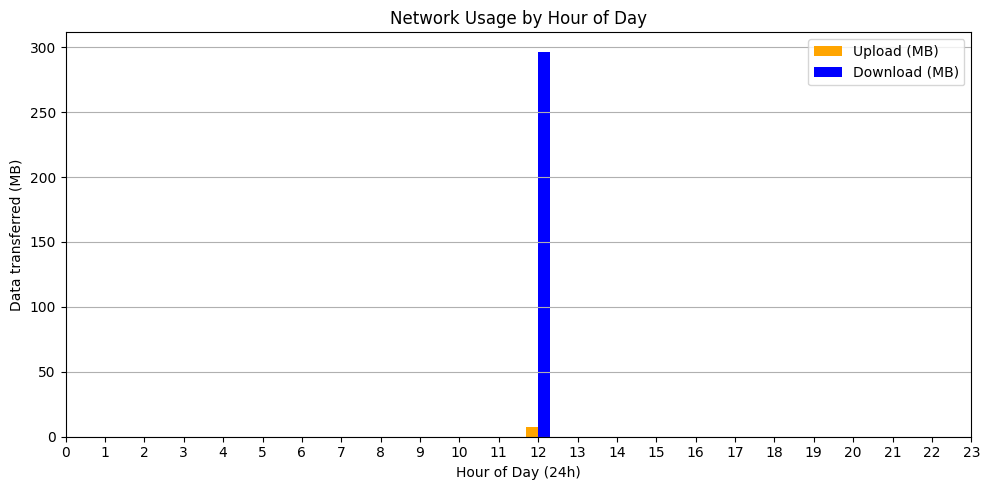

In [20]:
stop_monitoring()